In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import cv2
import json
import pickle,keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
plt.style.use('seaborn')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Captions

In [3]:
with open('/content/drive/My Drive/Flickr8k/Flickr_TextData/Flickr8k.token.txt') as f:
    data=f.read()
data=data.split('\n')[:-1] #last entry is empty

In [4]:
data[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

### Data Cleaning
stemming ,lemmatising , stopword removal techniques have not been performed while cleaning the captions so as to teach model write captions with correct english otherwise - a caption like 'A child in a pink dress is climbing up a set of stairs in an entry way' model will predict caption of form 'child pink dress climb set of stairs entry way' which doesn't make sense.

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    words=sentence.split()
    words = [word for word in words if len(word)>1]		
    sentence =  ' '.join(words)
    return sentence

In [14]:
captions={}
for i in range(len(data)):
    img_name,img_caption=data[i].split('\t')
    img_name=img_name.split('.jpg')[0]
    img_caption=clean_text(img_caption)
    if captions.get(img_name) is None:
        captions[img_name] = []
    captions[img_name].append(img_caption)

In [15]:
# print(captions)
with open("/content/drive/My Drive/image_captioning_files/cleaned_caption_description.json", "w") as file:
    json.dump(captions, file)

In [ ]:
with open("/content/drive/My Drive/image_captioning_files/cleaned_caption_description.json", "r") as file:
    captions=json.load(file)

### Load train and test data

In [17]:
train=None
test=None
with open('/content/drive/My Drive/Flickr8k/Flickr_TextData/Flickr_8k.trainImages.txt') as f:
    train=f.readlines()
with open('/content/drive/My Drive/Flickr8k/Flickr_TextData/Flickr_8k.testImages.txt') as f:
    test=f.readlines()

In [18]:
train=[c.split('.jpg')[0] for c in train]
test=[c.split('.jpg')[0] for c in test]

In [19]:
print(train[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


<start\> (start-of-sequence) and <end\> (end-of-sequence) characters are added to every caption to help our model determine when to start and - more importantly - end sequences.
Because while generating text(captions) model should know when it has to end otherwise it will keep predicting words and add them to the captions.  That's why we teach our model to decide the length of a caption on that by itself. when model will predict <end\> as next word for the caption, model should stop predicting more words.

In [20]:
#prepare train descriptions
train_descriptions={}
for t in train:
    train_descriptions[t]=[]
    for sent in captions[t]:
        new_caption='<start>'+sent+'<end>'
        train_descriptions[t].append(new_caption)

In [21]:
with open('/content/drive/My Drive/image_captioning_files/train_descriptions.json','w') as file:
    json.dump(train_descriptions,file)

In [4]:
with open('/content/drive/My Drive/image_captioning_files/train_descriptions.json','r') as file:
    train_descriptions=json.load(file)

### Using Resnet model to extract features from image 
- Resnet is used as an encoder
- output of 3rd last layer of resnet will be used as an encoding containing information about different features captured by resnet. These encodings will be later fed as input to the main model to predict captions.

In [23]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
# model.summary()

102973440/102967424 [==============================] - 1s 0us/step


In [24]:
new_model = Model(model.input,model.layers[-2].output)
# model.summary()

In [25]:
def get_image_encodings(img):
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [26]:
encoding_train = {}
for img_name in train:
    img_path='/content/drive/My Drive/Flickr8k/Images/'+img_name+'.jpg'
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = img.reshape((1,224,224,3)) 
    #resnet expects a batch of image so expanding dimensions
    # (224,224,3) -> (1,224,224,3)
    img = preprocess_input(img)
    encoding_train[img_name] = get_image_encodings(img)

In [27]:
encoding_test = {}
for img_name in test:
    img_path='/content/drive/My Drive/Flickr8k/Images/'+img_name+'.jpg'
    img = image.load_img(img_path,target_size=(224,224))
    img = image.img_to_array(img)
    img = img.reshape((1,224,224,3)) 
    img = preprocess_input(img)
    encoding_test[img_name] = get_image_encodings(img)

In [28]:
with open("/content/drive/My Drive/image_captioning_files/encoded_image_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
with open("/content/drive/My Drive/image_captioning_files/encoded_image_features_testdata.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [5]:
with open("/content/drive/My Drive/image_captioning_files/encoded_image_features.pkl","rb") as f:
    encoding_train=pickle.load(f)
with open("/content/drive/My Drive/image_captioning_files/encoded_image_features_testdata.pkl","rb") as f:
    encoding_test=pickle.load(f)

### creating Vocab

In [6]:
total_words=[]
for img_name in train_descriptions.keys():
    [total_words.append(i) for sent in train_descriptions[img_name] for i in sent.split()]
print('total words= {}'.format(len(total_words)))
count=np.array(np.unique(total_words,return_counts=True))
count=[(count[0][i],count[1][i])for i in range(count.shape[1])]
print('no of unique words= {}'.format(len(count))) #no of unique words

total words= 351525
no of unique words= 8522


In [7]:
#reducing size of vocab by removing words with frequency less than 10
size=10
vocab=[w[0] for w in count if int(w[1])>size]
print('no of unique words= {}'.format(len(vocab)))
vocab_size=len(vocab)+1

no of unique words= 1633


In [9]:
total_words.append('<start>')
total_words.append('<end>')

In [10]:
word_to_idx={}
idx_to_word={}
# 0th index will be used to store character that will be used for padding while making 
# all captions of equal length (length of maximum sentence)
# <start> dog (padding) (padding) (padding)
# <start> dog is (padding) (padding)
# <start> dog is playing 
for i,word in enumerate(vocab):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [8]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

37


### Data Generator
- Data is very big that loading a batch one by one in memory while training is adviced.

In [11]:
def DataGenerator(train_descriptions,batch_size,encoding_train,word_to_idx):
    X1,X2,y=[],[],[]
    #x1- image features, x2=captions ,y = next word that should be predicted
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = keras.utils.to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

### Preparing Word Embeddings

In [12]:
def Get_word_embeddings():
    word_embeddings={}
    with open('/content/drive/My Drive/Flickr8k/glove.6B.50d.txt',encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddings = np.asarray(values[1:],dtype='float32')
            word_embeddings[word] = embeddings
    return word_embeddings

In [13]:
embedding_index=Get_word_embeddings()

In [14]:
#Embedding Matrix
emb_dim = 50
embedding_matrix = np.zeros((vocab_size,emb_dim))
for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)    
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [15]:
with open('/content/drive/My Drive/image_captioning_files/embedding_matrix.pkl','wb') as f:
    pickle.dump(embedding_matrix,f)

In [16]:
with open('/content/drive/My Drive/image_captioning_files/embedding_matrix.pkl','rb') as f:
    embedding_matrix=pickle.load(f)

### Model

In [17]:
#Branch1 - for image features
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [18]:
#Branch2 - for Captions
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [20]:
#Merging the branches
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

In [21]:
# Final Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 50)       81700       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [22]:
# Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [23]:
optim = keras.optimizers.Adam(0.001)
model.compile(optimizer=optim,loss='categorical_crossentropy')

### Training

In [25]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = DataGenerator(train_descriptions,number_pics_per_bath,encoding_train,word_to_idx)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 36s 18ms/step - loss: 2.6102


In [27]:
for i in range(epochs):
    generator = DataGenerator(train_descriptions,number_pics_per_bath,encoding_train,word_to_idx)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 35s 18ms/step - loss: 2.4050


In [28]:
model.save('/content/drive/My Drive/image_captioning_files/model_weights/model_one.h5')

In [29]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [30]:
for i in range(epochs):
    generator = DataGenerator(train_descriptions,number_pics_per_bath,encoding_train,word_to_idx)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1000/1000 [==============================] - 27s 27ms/step - loss: 2.2691


In [31]:
model.save('/content/drive/My Drive/image_captioning_files/model_weights/model_final.h5')

In [32]:
for i in range(epochs):
    generator = DataGenerator(train_descriptions,number_pics_per_bath,encoding_train,word_to_idx)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1000/1000 [==============================] - 29s 29ms/step - loss: 2.2338


In [33]:
model.save('/content/drive/My Drive/image_captioning_files/model_weights/model_final.h5')

In [ ]:
model = load_model('/content/drive/My Drive/image_captioning_files/model_weigh ts/model.h5')

### Predictions

In [48]:
def predict_caption(photo):
    in_text = '<start>'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

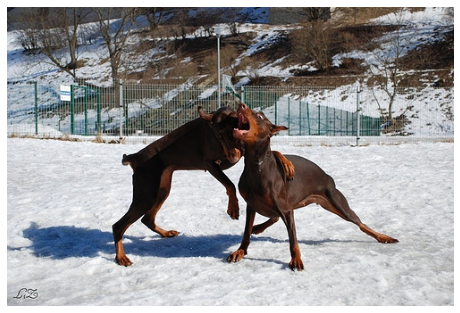

UnknownError: ignored

In [49]:
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread('/content/drive/My Drive/Flickr8k/Images/'+pic+'.jpg')
plt.style.use('seaborn')
plt.axis('off')
plt.imshow(x)
plt.show()
print("Greedy:",predict_caption(image))